<a href="https://colab.research.google.com/github/ParkSlingshot/-/blob/main/Transfer_Learning_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
(raw_train, raw_validation, raw_test),metadata = tfds.load('cats_vs_dogs',
                                                       split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                       with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7ZQT2X/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


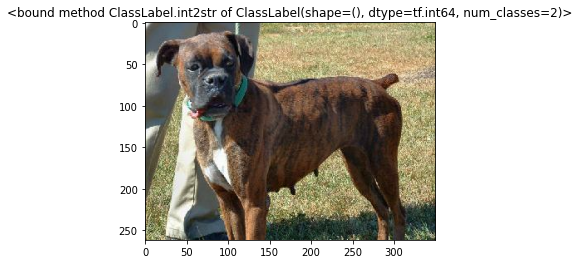

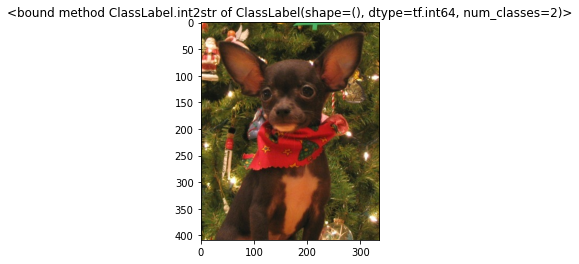

In [3]:
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2) : 
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name)

In [4]:
size = 160

def format_example(image,label):
  image = tf.cast(image,tf.float32)
  image = (image/127.5)-1
  image = tf.image.resize(image,(size,size))
  return image,label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [6]:
batch_size = 32
Shuffle_size  =10000

train_batches = train.shuffle(Shuffle_size).batch(batch_size)
test_batches = test.shuffle(Shuffle_size).batch(batch_size)
validation_batches = validation.shuffle(Shuffle_size).batch(batch_size)

In [7]:
for img_batch, label_batch in train_batches.take(1) :
  pass

IMG_shape = (160,160,3)
base_model = keras.applications.MobileNetV2(input_shape=IMG_shape, include_top=False, weights='imagenet')
feature_batch = base_model(img_batch)
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
gal = keras.layers.GlobalAveragePooling2D()
fba = gal(feature_batch)
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(fba)


In [9]:
model = keras.Sequential([
                          base_model, gal, prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
rate = 1e-4
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=rate),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
history = model.fit(train_batches, epochs=10, validation_data= validation_batches)

Epoch 1/10
582/582 [==============================] - 79s 96ms/step - loss: 0.1880 - accuracy: 0.9269 - val_loss: 0.0855 - val_accuracy: 0.9725
Epoch 2/10
582/582 [==============================] - 75s 95ms/step - loss: 0.0729 - accuracy: 0.9737 - val_loss: 0.0638 - val_accuracy: 0.9764
Epoch 3/10
582/582 [==============================] - 73s 92ms/step - loss: 0.0596 - accuracy: 0.9780 - val_loss: 0.0564 - val_accuracy: 0.9794
Epoch 4/10
582/582 [==============================] - 75s 96ms/step - loss: 0.0536 - accuracy: 0.9805 - val_loss: 0.0525 - val_accuracy: 0.9802
Epoch 5/10
582/582 [==============================] - 73s 92ms/step - loss: 0.0500 - accuracy: 0.9814 - val_loss: 0.0500 - val_accuracy: 0.9811
Epoch 6/10
582/582 [==============================] - 75s 95ms/step - loss: 0.0477 - accuracy: 0.9825 - val_loss: 0.0485 - val_accuracy: 0.9828
Epoch 7/10
582/582 [==============================] - 73s 92ms/step - loss: 0.0458 - accuracy: 0.9828 - val_loss: 0.0474 - val_accuracy:

In [34]:
def plot_graph(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

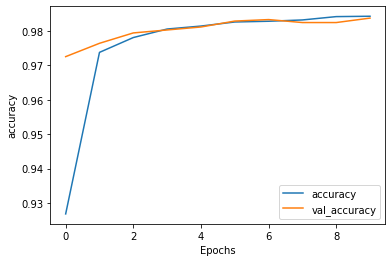

In [35]:
plot_graph(history, 'accuracy')

#Fine Tune

In [36]:
base_model.trainable=True
fine_tune_at = 100

In [37]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainabel = False

In [40]:
model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = keras.optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['accuracy'])

In [41]:
total_epochs = 20

In [46]:
fine_history = model.fit(train_batches, epochs= total_epochs, validation_data = validation_batches, initial_epoch = history.epoch[-1])

Epoch 10/20
582/582 [==============================] - 162s 241ms/step - loss: 0.0884 - accuracy: 0.9665 - val_loss: 0.0931 - val_accuracy: 0.9781
Epoch 11/20
582/582 [==============================] - 160s 241ms/step - loss: 0.0310 - accuracy: 0.9889 - val_loss: 0.0794 - val_accuracy: 0.9858
Epoch 12/20
582/582 [==============================] - 158s 238ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.1144 - val_accuracy: 0.9850
Epoch 13/20
582/582 [==============================] - 158s 238ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.1069 - val_accuracy: 0.9845
Epoch 14/20
582/582 [==============================] - 156s 236ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.1045 - val_accuracy: 0.9858
Epoch 15/20
582/582 [==============================] - 159s 240ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.1531 - val_accuracy: 0.9798
Epoch 16/20
582/582 [==============================] - 158s 238ms/step - loss: 0.0061 - accuracy: 0.9976 - val_loss: 0

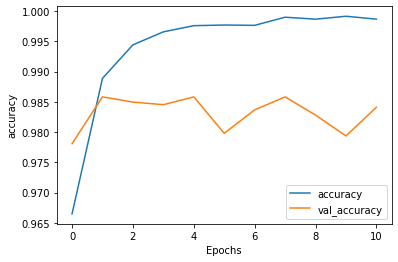

In [48]:
plot_graph(fine_history, 'accuracy')